In [2]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio, display
import tensorflow as tf

# modify this path to where your pickles are stored
data_dir = '../tracks_data/'
pickle_files = glob.glob(f'{data_dir}*_spectrogram.pkl')
print(f'Found {len(pickle_files)} spectrogram pickles')


Found 7997 spectrogram pickles


# Example for a single track

In [99]:
example_path = pickle_files[10]
with open(example_path, 'rb') as f:
    data = pickle.load(f)

# Inspect keys and shapes
print('Keys in pickle:', data.keys())
spec = data['spectrogram']
print('track_id:', data['track_id'])
print('Spectrogram shape:', spec.shape)
print('Metadata:', data['metadata'])

Keys in pickle: dict_keys(['track_id', 'spectrogram', 'metadata'])
track_id: 000197
Spectrogram shape: (513, 431)
Metadata: {'track_title': 'piano 2', 'artist_name': 'ed askew', 'genre': 'Folk', 'genre_id': 2}


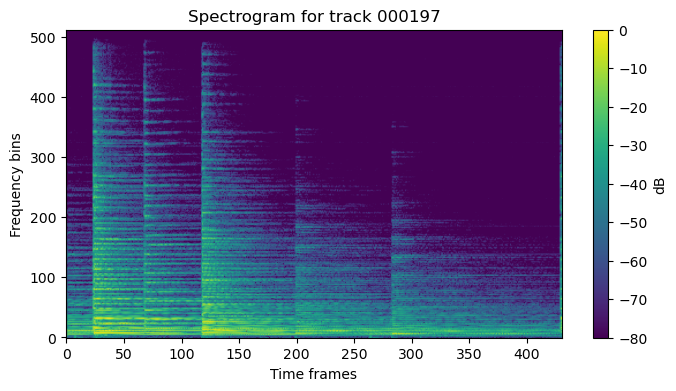

In [100]:
plt.figure(figsize=(8, 4))
plt.imshow(spec, origin='lower', aspect='auto')
plt.title(f"Spectrogram for track {data['track_id']}")
plt.xlabel('Time frames')
plt.ylabel('Frequency bins')
plt.colorbar(label='dB')
plt.show()

# Reconstruction

In [7]:
spec.shape

(513, 431)

In [101]:
spec_lin = librosa.db_to_amplitude(spec)
y = librosa.griffinlim(
    spec_lin,
    n_fft=1024,
    hop_length=512,
    n_iter=32
)

display(Audio(data=y, rate=22050))

In [ ]:
# For memory demo, load first N files
N = min(10, len(pickle_files))
batch = []
meta = []
for path in pickle_files[:N]:
    with open(path, 'rb') as f:
        d = pickle.load(f)
    batch.append(d['spectrogram'])
    meta.append(d['metadata']['genre_id'])
batch_array = np.stack(batch, axis=0)  # shape (N, F, T)
labels = np.array(meta)
print('Batch array shape:', batch_array.shape)
print('Labels:', labels)

# preprocess

In [ ]:
%load_ext autoreload
%autoreload 2

from preprocess import batch_generator, load_batch, load_encoders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_list = 'train.pkl'
batch_size = 32
pickle_dir = '../tracks_data/'
norm = 'minmax'  # or 'standardize'
artist_le, genre_le = load_encoders('artist_encoder.pkl', 'genre_encoder.pkl')

# Example: load first batch from train set
train_ids = pickle.load(open(train_list, 'rb'))

for batch_id in batch_generator(train_ids, batch_size):
    spec_b, art_b, gen_b = load_batch(
        batch_id, pickle_dir,
        artist_le, genre_le,
        batch_size=batch_size,
        norm_method=norm
    )
    print(f"Example batch: specs={spec_b.shape}, artists={art_b.shape}, genres={gen_b.shape}")
    # Break after first batch for demonstration
    break

Example batch: specs=(32, 513, 431, 1), artists=(32,), genres=(32,)


In [39]:
first_8 = train_ids[:8]
with open('train8.pkl', 'wb') as f:
    pickle.dump(first_8, f)

In [36]:
test_list = 'diffusion_data/test.pkl'
test_ids = pickle.load(open(test_list, 'rb'))

In [40]:
first_two = test_ids[:2]
with open('test2.pkl', 'wb') as f:
    pickle.dump(first_two, f)

In [63]:
first_two

['063257', '056466']

In [27]:
gen_b

array([5, 6, 0, 5, 2, 6, 7, 2, 6, 6, 2, 1, 1, 7, 5, 4, 4, 7, 7, 6, 5, 3,
       6, 7, 1, 0, 7, 1, 7, 3, 5, 3])

# Generated Sample

In [102]:
sample = pickle.load(open('diffusion_data/generated_samples/000197_generated.pkl', 'rb'))
spec_rec = sample['spectrogram'][0]

# spec_rec = np.clip(spec_rec, -80, 0)
spec_rec = (spec_rec - spec_rec.min()) / (spec_rec.max() - spec_rec.min()) * 80 - 80

In [91]:
# S.shape
spec_lin = librosa.db_to_amplitude(spec_rec)
y = librosa.griffinlim(
    spec_lin,
    n_fft=1024,
    hop_length=512,
    n_iter=32
)

display(Audio(data=y, rate=22050))

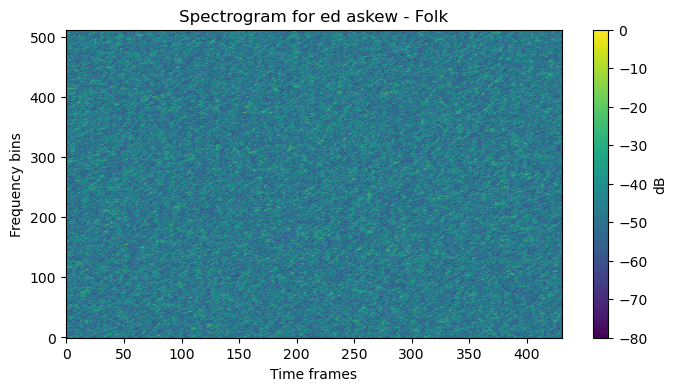

In [103]:
# Extract the spectrogram and squeeze it in case of extra dimensions

# Plot the spectrogram with artist and genre information in the title
plt.figure(figsize=(8, 4))
plt.imshow(spec_rec, origin='lower', aspect='auto')
plt.title(f"Spectrogram for {sample['metadata']['artist_name']} - {sample['metadata']['genre']}")
plt.xlabel('Time frames')
plt.ylabel('Frequency bins')
plt.colorbar(label='dB')
plt.show()